# Exploratory data analysis
## Data preparation

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline


In [3]:
directory_path = os.getcwd()
file_path = os.path.join(directory_path, 'Healthcare-Diabetes.csv')

In [4]:
diabetes = pd.read_csv(file_path, index_col = 0)
#Checking the first few rows
display(diabetes.head(3))


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1


In [5]:
#Checking datat types of different columns and whether they contain any missing values
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2768 entries, 1 to 2768
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2768 non-null   int64  
 1   Glucose                   2768 non-null   int64  
 2   BloodPressure             2768 non-null   int64  
 3   SkinThickness             2768 non-null   int64  
 4   Insulin                   2768 non-null   int64  
 5   BMI                       2768 non-null   float64
 6   DiabetesPedigreeFunction  2768 non-null   float64
 7   Age                       2768 non-null   int64  
 8   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 216.2 KB
None


In [6]:
#Checking if the columns Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction and Age have 0 values
columns = diabetes.drop(['Pregnancies','Outcome'], axis = 1)
columns = columns.columns
columns
missing_count = pd.Series({column: (diabetes[column]==0).sum() for column in columns})
display(missing_count)

Glucose                       18
BloodPressure                125
SkinThickness                800
Insulin                     1330
BMI                           39
DiabetesPedigreeFunction       0
Age                            0
dtype: int64

In [7]:
#Setting 0 values to to NaN
for column in columns:
    diabetes.loc[diabetes[column]==0, column] = np.nan

missing_count_2 = diabetes.drop(['Pregnancies', 'Outcome'],axis = 1).isna().sum()
display(missing_count_2)
#confirm missing_count_2 is equal to missing_count to confirm that 0 values were converted to NaN
print('Are the 2 Series objects equal?\n',(missing_count_2 == missing_count).all())


Glucose                       18
BloodPressure                125
SkinThickness                800
Insulin                     1330
BMI                           39
DiabetesPedigreeFunction       0
Age                            0
dtype: int64

Are the 2 Series objects equal?
 True


In [8]:
#Check proportion of missing values in each column
display(missing_count_2/len(diabetes))


Glucose                     0.006503
BloodPressure               0.045159
SkinThickness               0.289017
Insulin                     0.480491
BMI                         0.014090
DiabetesPedigreeFunction    0.000000
Age                         0.000000
dtype: float64

In [9]:
#The columns Glucose, BloodPressure and BMI have a very small proportion of missing data. We will drop the rows with missing rows
diabetes = diabetes.dropna()
#Confirming that we have indeed dropped missing values in those columns
display(diabetes.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

To investigate the nature of missing values in SkinThickness and Insulin, we need to use a missing value plot. The missingno python package is an excellent tool for this

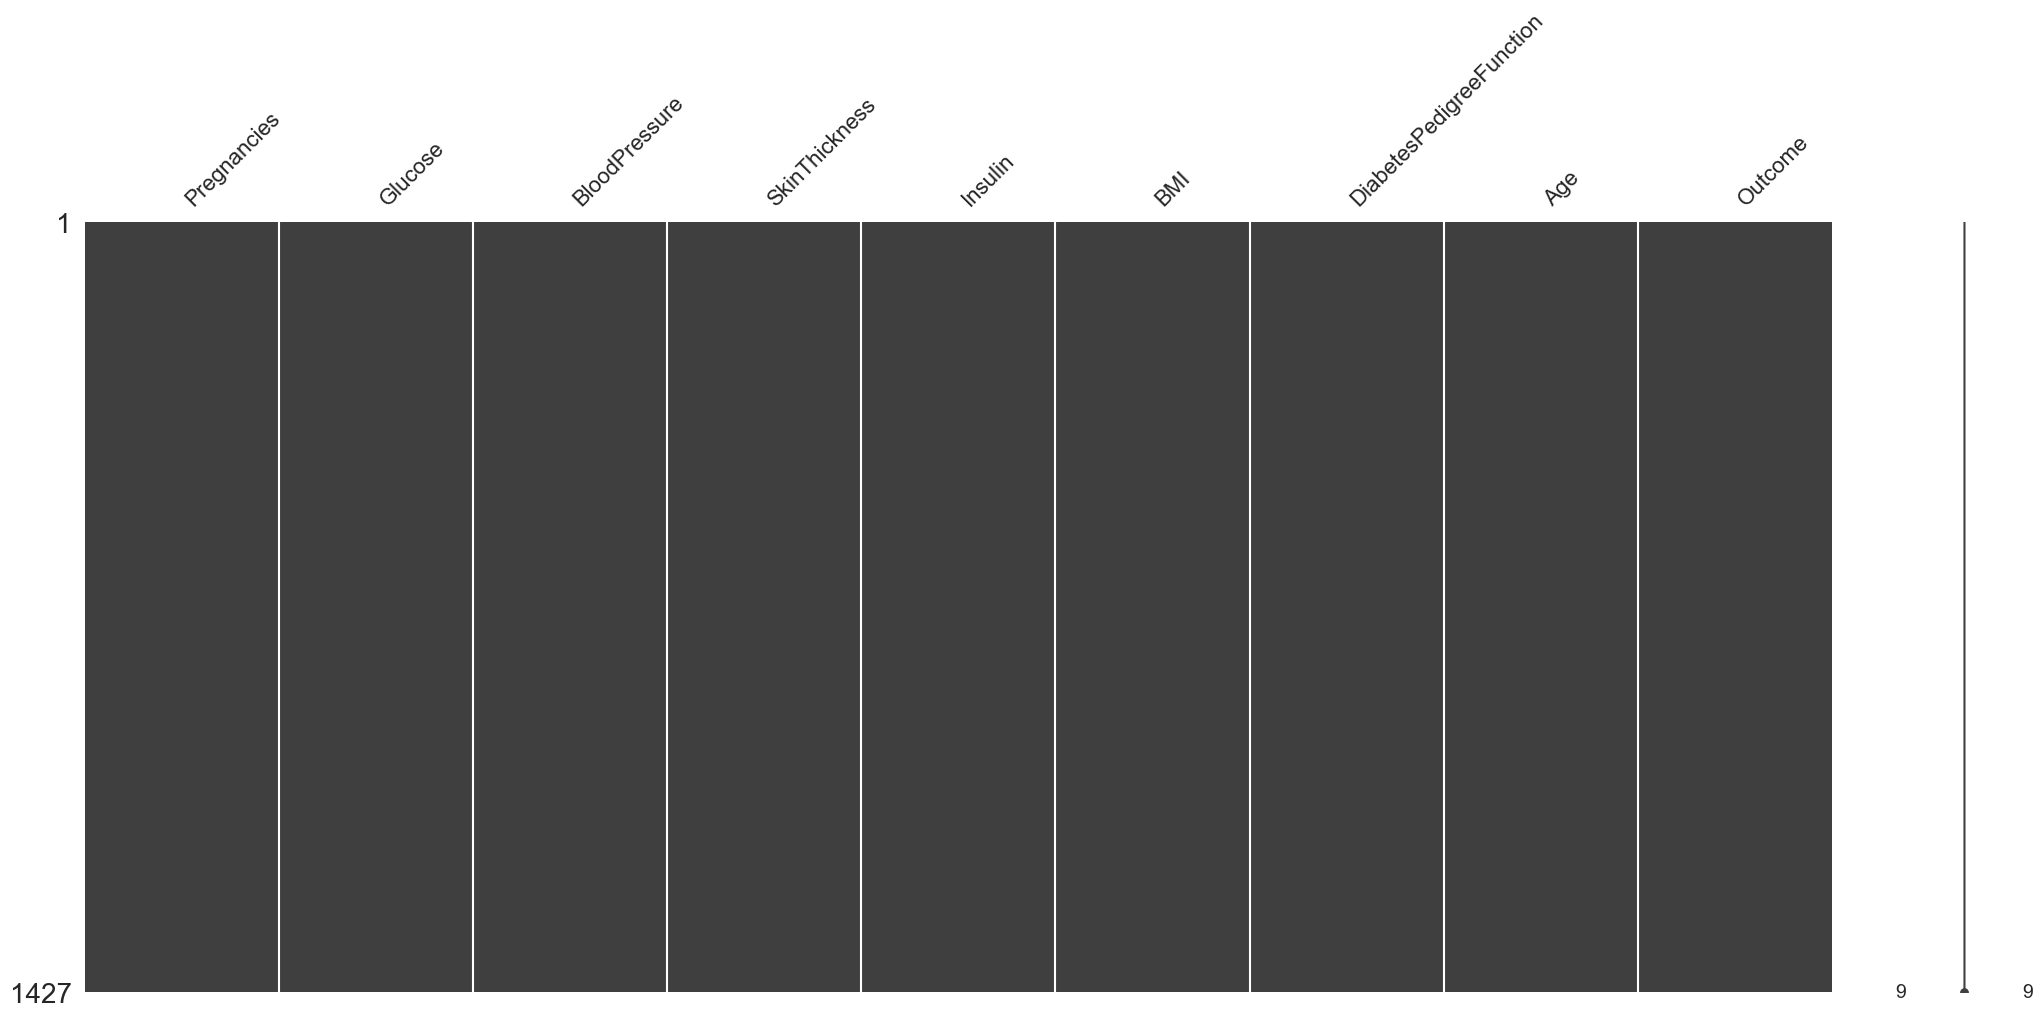

<Figure size 1000x600 with 0 Axes>

In [10]:
#Now we analyze the nature of missing data in SkinThickness and Insulin to know how we should go about replacing the data
diabetes_copy = diabetes.copy()
sns.set()
msno.matrix(diabetes_copy)
plt.figure(figsize=(10, 6))
plt.show()

Missingness in both columns appears to be random. However, we know insulin is involved in the regulation of glucose level, so we will sort our dataframe by glucose and see if there exists any relationship between glucose level and missing data on insulin.

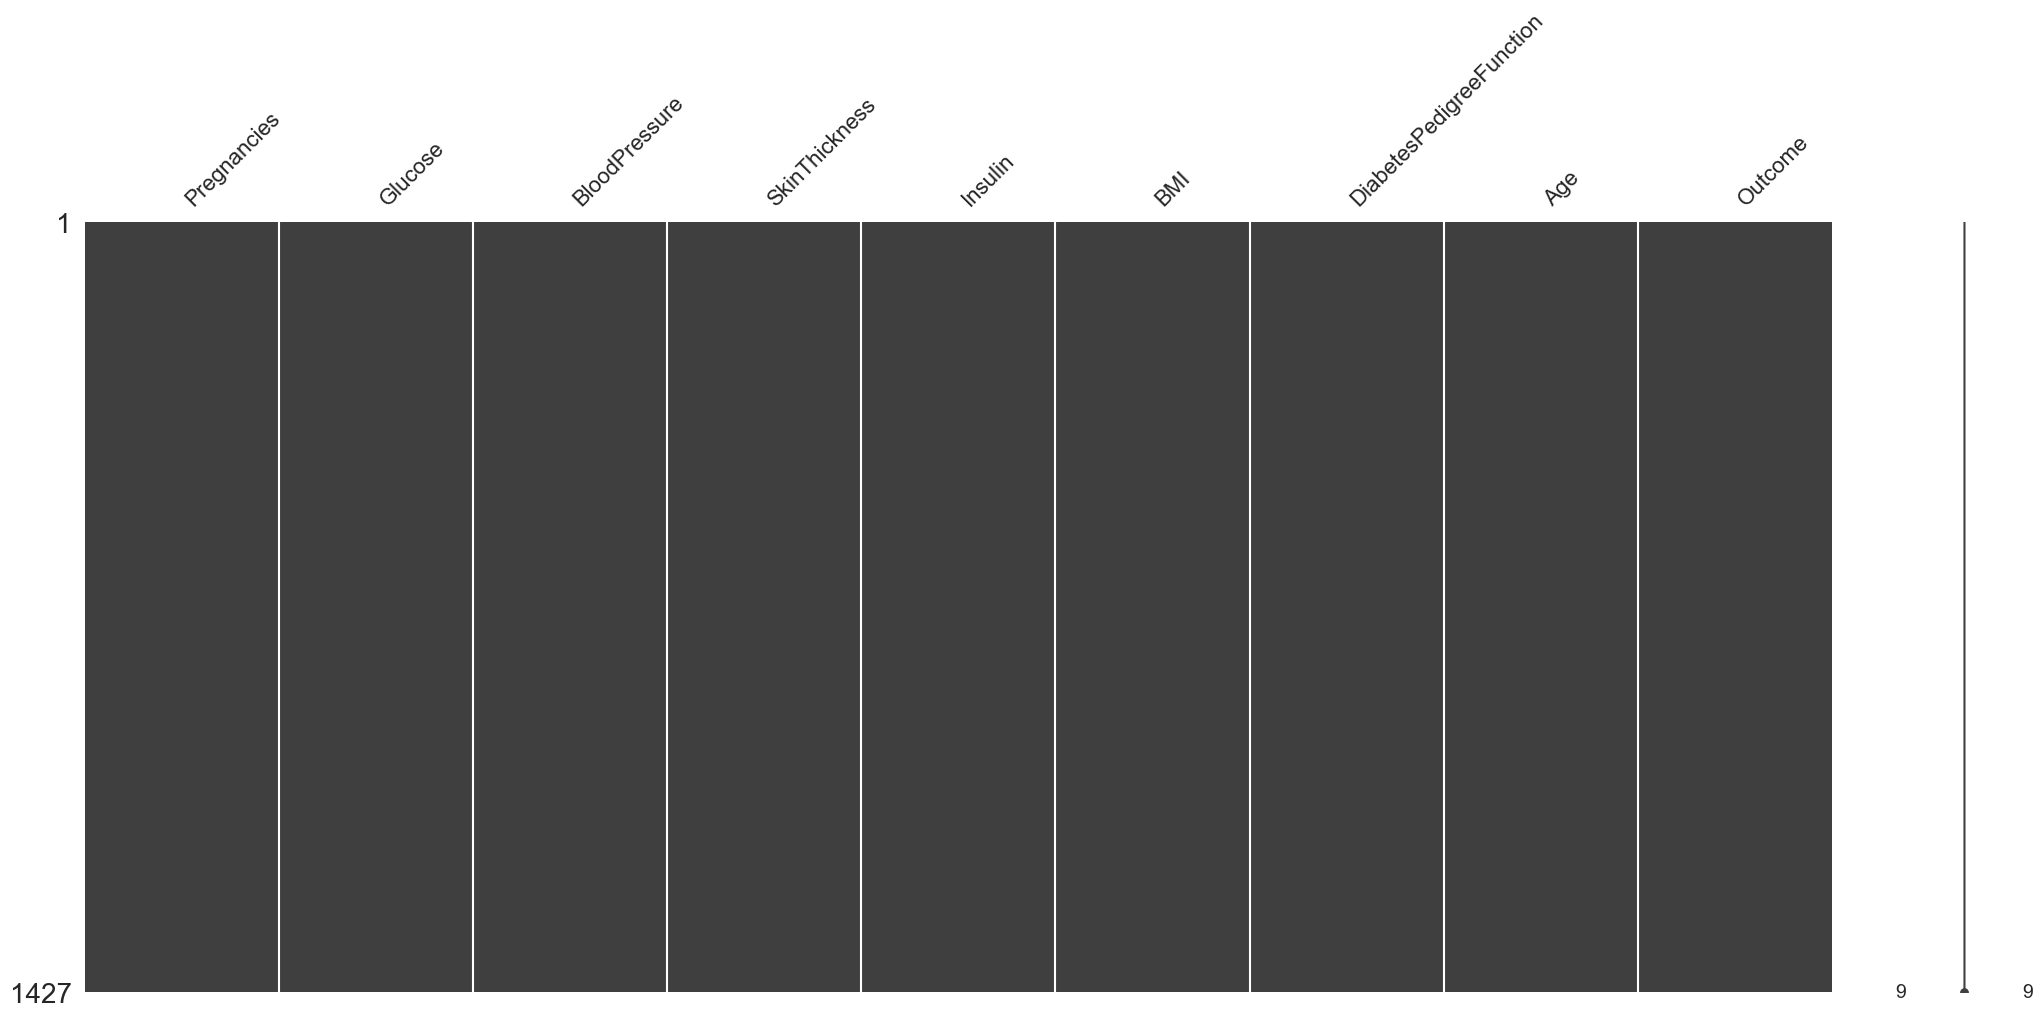

In [11]:
diabetes_sorted = diabetes_copy.sort_values(by = 'Glucose')
msno.matrix(diabetes_sorted)
plt.show()

We see that the missing values occur randomly even after sorting by glucose, we will therefore investigate the distribution of the values of the 2 columns before deciding how to deal with the missing data. We will do this with the help of histograms and kde plots. We will plot separate plots divided along the values of the Outcome column. This will help us identify differences in distribution based on the response variable.

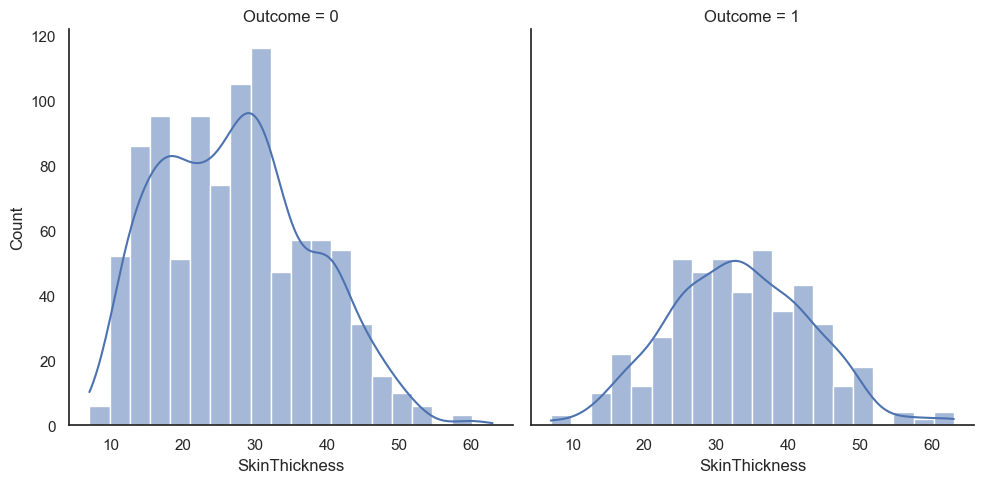

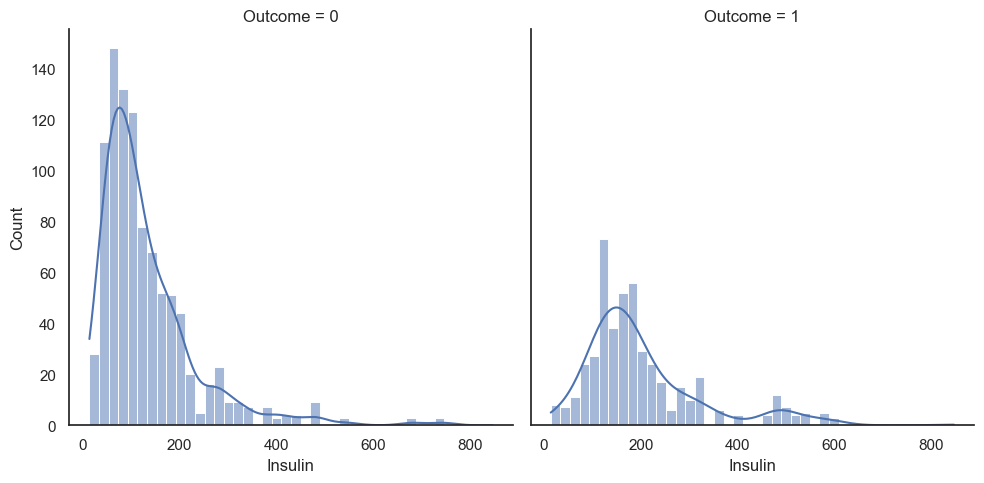

In [12]:
missing_cols = ['SkinThickness','Insulin']
sns.set_style('white')
for col in missing_cols:
   sns.displot(diabetes_copy,x = col, kde=True, col = 'Outcome')
   plt.show()

From the above 4 plots, we see that all values are approximately normally distributed, but the distribution mean seems to vary significantly depending on the value of the Outcome column. We will therefore replace these values with this in mind, that is;
Missing values of skinthickness corresponding to outcome variable 0 will be replaced with their mean, and so on for the other 3 categories.

In [13]:
#Finding the means per category
means_st_isln = diabetes.groupby('Outcome')[['SkinThickness', 'Insulin']].mean()
display(means_st_isln)

,SkinThickness,Insulin
Outcome,,
0,27.288542,131.221875
1,33.224839,202.432548


In [14]:
len(diabetes)

1427

Every  missing data has been replaced appropriately, now we do another plot to see the new distribution of these columns;

## Model fitting
### Baseline model
A Baseline model is a model that predicts absence of event only. It's accuracy is equal to the proportion of true negatives in the entire dataset. The Baseline model is key in investigating the gain in accuracy that results from fitting a predictor model. We will use the .value_counts() method on the Outcome column to investigate the proportion of true negatives and hence the accuracy of our baseline model.

In [15]:
Outcome_proportion = diabetes['Outcome'].value_counts(normalize = True)
display(Outcome_proportion)

Outcome
0    0.67274
1    0.32726
Name: proportion, dtype: float64

We see that the accuracy of the baseline model is 66%. This will be one of the metrics we consider when evaluating the accuracy of our fitted model.
We can also make use of a countplot to visualize the counts for the two Outcome variables

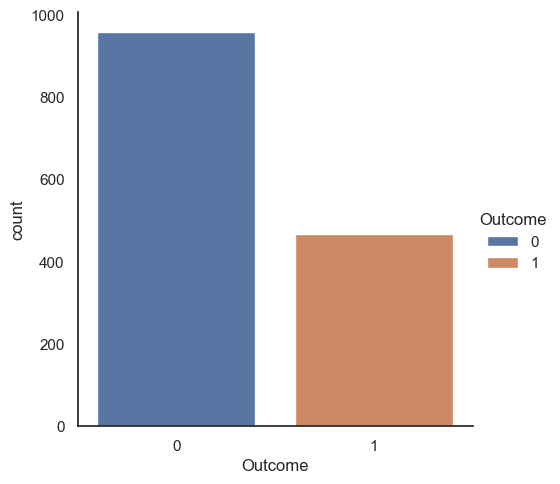

In [16]:
sns.catplot(data = diabetes, x = 'Outcome', kind = 'count', hue = 'Outcome')
plt.show()

### Correlation of different variables
Before fitting the model, it is also of essence to check for correlation between the predictor variables. This is important because highly correlated variables can lead Multicollinearity and overfitting. To investigate correlations between different columns, we will use a heatmap. 


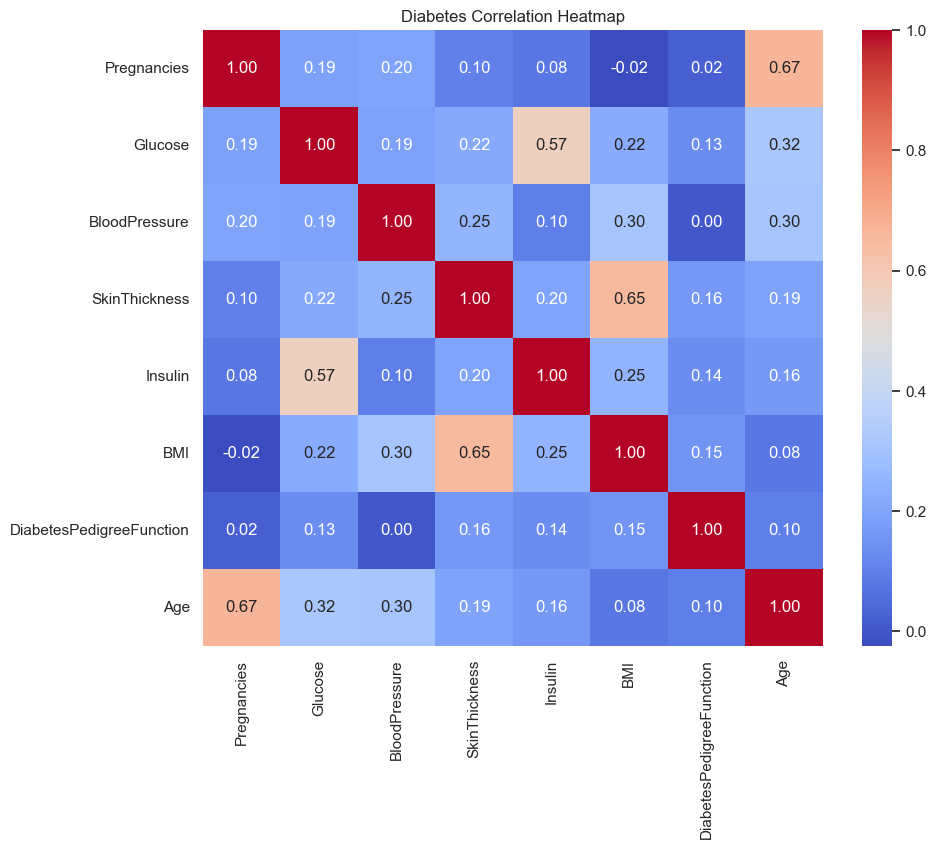

In [17]:
corr_matrix = diabetes.drop('Outcome', axis = 1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Diabetes Correlation Heatmap')
plt.show()


There exists a considerable level of correlation between pregnancies and age, insulin and glucose and age and blood pressure.

### The model

In [18]:

import stepwise_regression
from stepwise_regression import step_reg

# Load your dataset

# Separate predictors (X) and target variable (y)
X = diabetes.drop(columns=["Outcome"])
y = diabetes["Outcome"]

# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
print((len(X_test),len(X_train)))
# Perform stepwise regression
selected_features = step_reg.forward_regression(X_train, y_train, 0.01, True)
print("Selected features:", selected_features)
#fit in a binary logistic model
binary_logistic_model = LogisticRegression()
binary_logistic_model.fit(X_train[selected_features], y_train)
predictions = binary_logistic_model.predict(X_test[selected_features])
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)
print(classification_report(y_test, predictions))
blm_cf = confusion_matrix(y_test, predictions)
print(blm_cf)
#coefficients
coefficients = binary_logistic_model.coef_
for feature, coef in zip(selected_features, coefficients[0]):
    print(f"{feature}: {coef}")
#constant
intercept = binary_logistic_model.intercept_
print('intercept',intercept)

(429, 998)
Add  Glucose                        with p-value 6.89566e-72
Add  Age                            with p-value 1.64318e-11
Add  BMI                            with p-value 7.674e-09
Add  Pregnancies                    with p-value 0.00329123
Selected features: ['Glucose', 'Age', 'BMI', 'Pregnancies']
Accuracy: 0.7925407925407926
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       289
           1       0.73      0.59      0.65       140

    accuracy                           0.79       429
   macro avg       0.77      0.74      0.75       429
weighted avg       0.79      0.79      0.79       429

[[258  31]
 [ 58  82]]
Glucose: 0.038000438714010015
Age: 0.03399422164584156
BMI: 0.0757231488765731
Pregnancies: 0.08445763433943701
intercept [-9.50976304]


In [19]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train[selected_features],y_train)
rf_predictions = random_forest_model.predict(X_test[selected_features])
rf_accuracy = accuracy_score(y_test,rf_predictions)
print(rf_accuracy)
print(classification_report(y_test, rf_predictions))
rf_cm = confusion_matrix(y_test, rf_predictions)
print(rf_cm)
feature_importances = random_forest_model.feature_importances_
feature_importance_pairs = zip(selected_features, feature_importances)
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
print(sorted_feature_importance)

0.9953379953379954
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       289
           1       0.99      1.00      0.99       140

    accuracy                           1.00       429
   macro avg       0.99      1.00      0.99       429
weighted avg       1.00      1.00      1.00       429

[[287   2]
 [  0 140]]
[('Glucose', 0.4305309525313619), ('BMI', 0.23464745974112886), ('Age', 0.21241400329967103), ('Pregnancies', 0.12240758442783814)]


### Feature importance plot

Text(0.5, 1.0, 'Feature importance plot')

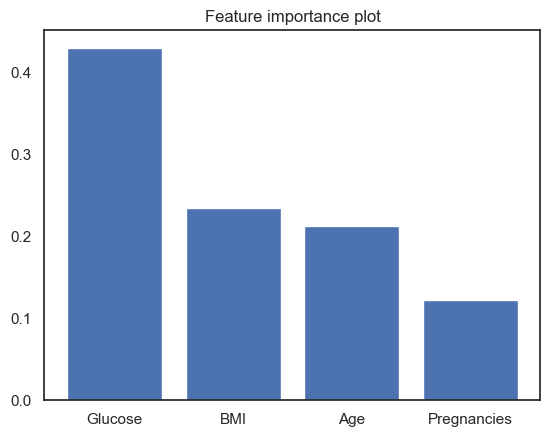

In [20]:
my_dict = {'Feature':['Glucose','BMI','Age','Pregnancies'],
          'Feature importance':[0.4305,0.2346,0.2124,0.1224]}
mi_df = pd.DataFrame(my_dict)
plt.bar(mi_df.Feature, mi_df['Feature importance'])
plt.title('Feature importance plot')

### Odds

In [21]:
len(X_train)

998

In [22]:
diabetes.groupby('Outcome')['SkinThickness'].mean()

Outcome
0    27.288542
1    33.224839
Name: SkinThickness, dtype: float64

In [23]:
len(X_train)

998

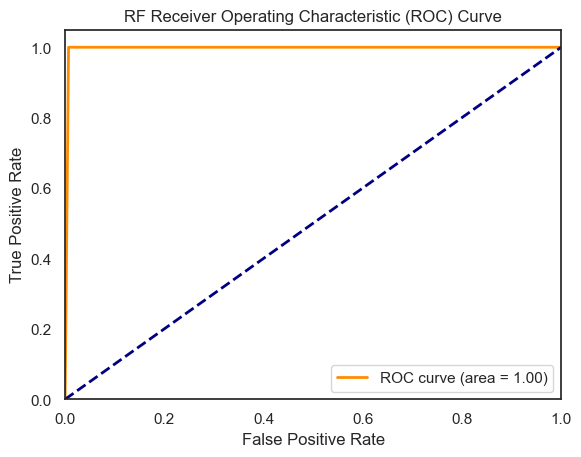

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have trained your classifier and obtained predicted probabilities
# y_test: true labels of the test set
# y_pred_proba: predicted probabilities of the positive class (label 1) from your classifier

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, rf_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [25]:
len(X_train)

998

In [26]:
diabetes.shape

(1427, 9)

In [27]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [28]:
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## Univariate analysis of selected featurers


In [29]:
diabetes[selected_features].describe()

,Glucose,Age,BMI,Pregnancies
count,1427.000000,1427.000000,1427.000000,1427.000000
mean,122.783462,30.723896,33.246811,3.217239
std,30.700175,10.086415,7.076903,3.178938
min,56.000000,21.000000,18.200000,0.000000
25%,99.000000,23.000000,28.400000,1.000000
50%,120.000000,27.000000,33.300000,2.000000
75%,143.000000,36.000000,37.400000,5.000000
max,198.000000,81.000000,67.100000,17.000000


## Distribution of selected features

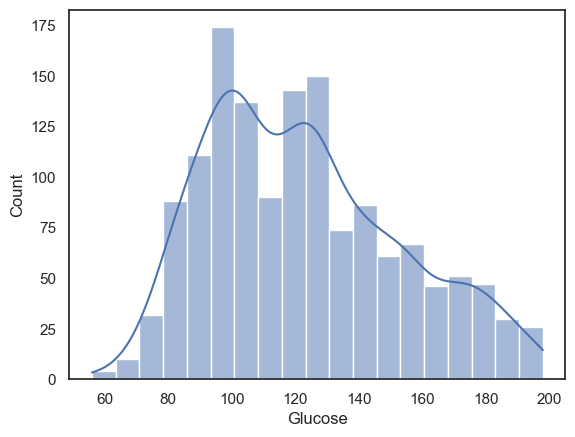

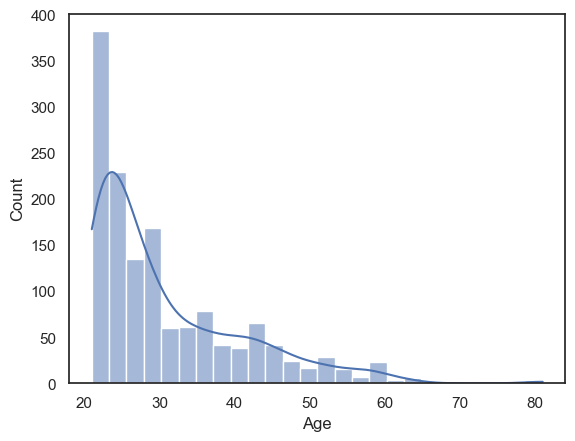

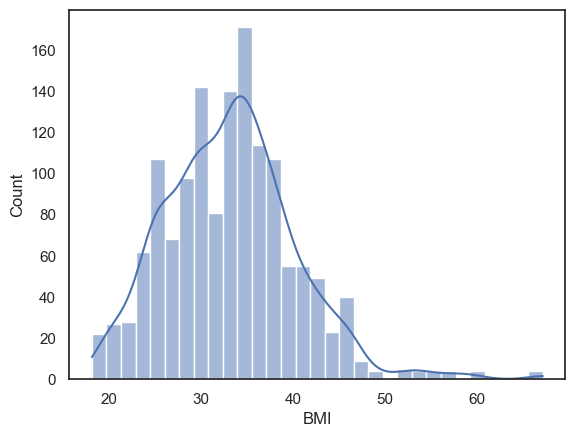

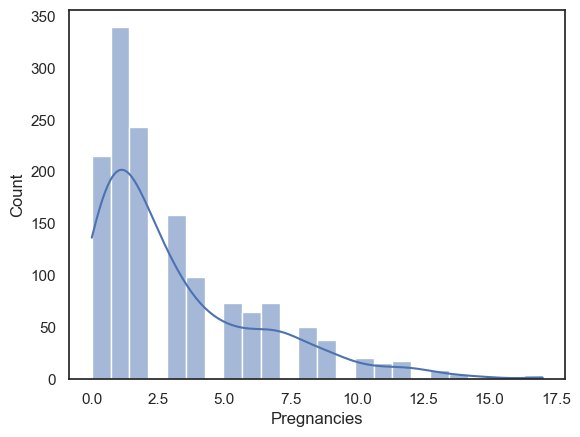

In [30]:
for column in selected_features:
    sns.histplot(diabetes[column], kde = True)
    plt.show()

## Proof of no multicollinearity

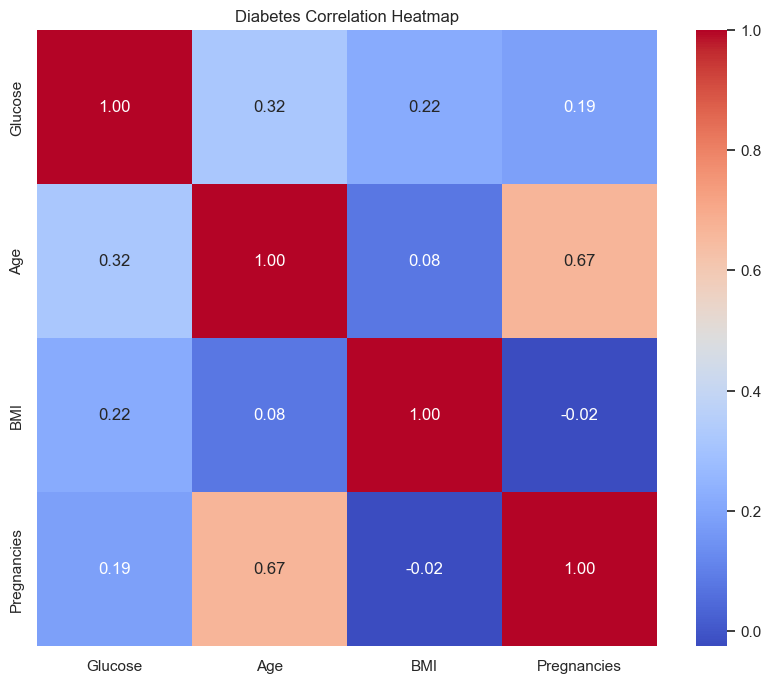

<Figure size 640x480 with 0 Axes>

In [31]:
corr_matrix = diabetes[selected_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Diabetes Correlation Heatmap')
plt.show()
plt.savefig('diabets_correlation_heatmap.PNG')

In [32]:
dictm = {'Feature':['Glucose','Age','BMI','Pregnancies'],
       'Coefficient':[0.038, 0.034, 0.076, 0.084]}
my_df = pd.DataFrame(dictm)
my_df['odds_ratio'] = round(np.exp(my_df['Coefficient']),4)
my_df

,Feature,Coefficient,odds_ratio
0,Glucose,0.038,1.0387
1,Age,0.034,1.0346
2,BMI,0.076,1.0790
3,Pregnancies,0.084,1.0876
